In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
era5_energy_only = xr.open_dataset('../data/etdata/ERA5_energy_only.nc')
era5_energy_only = era5_energy_only.rename({'latitude': 'y', 'longitude': 'x'})
# add crs to the data
era5_energy_only = era5_energy_only.rio.write_crs("epsg:4326")
# open ucrb boundary
ucrb = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
# clip era5 data to ucrb
era5_energy_only_clipped = era5_energy_only.rio.clip(ucrb.geometry, crs=ucrb.crs)
# sort by time
era5_energy_only_clipped = era5_energy_only_clipped.sortby('time')

In [3]:
# add days per month to the data
era5_energy_only_clipped['days_per_month'] = era5_energy_only_clipped.time.dt.days_in_month
# convert J/m2 to W/m2
era5_energy_only_clipped['ssr'] = era5_energy_only_clipped.ssr / (3600)
era5_energy_only_clipped['str'] = era5_energy_only_clipped.str / (3600)

In [4]:
era5_net = era5_energy_only_clipped.ssr + era5_energy_only_clipped.str
era5_net = era5_net.rename('net_radiation')
era5_net = era5_net.rio.write_crs("epsg:4326")

In [6]:
# energy only et 
rho = 1000
L = 2.5e6
era5_energy_only_clipped['et_ee'] = 0.8*86400*1000*(era5_energy_only_clipped.ssr + era5_energy_only_clipped.str) / (rho * L)
# save to netcdf
# era5_energy_only_clipped.to_netcdf('../data/etdata/ERA5_energy_only_clipped.nc')

In [7]:
da = rxr.open_rasterio('../data/geodata/nlcd_landcover/nlcd_UCRB_4326.tif').squeeze()
# replace values less than 0 with nan
da = da.where(da>=0, np.nan)

### <a id='toc4_1_2_'></a>[PRISM UCRB Temperature](#toc0_)

In [8]:
# Open PRISM temperature data
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_ucrb.nc')
# reprject to match the UCRB boundary
prism_tmean = prism_tmean.rio.reproject(4326)
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True).sel(month=slice('1930-01-01','2022-09-30'))


In [9]:
# add the year as a new dimension to prism_tmean
prism_tmean = prism_tmean.assign_coords(year=prism_tmean['month'].dt.year)

# make a copy to use later
prism_tmean_copy = prism_tmean.copy()
prism_tmean_copy['month'] = prism_tmean_copy['month'].dt.year

In [10]:
# filter to treed areas (41,42,43)
treed_areas_fine = da.where(da.isin([41,42,43]),drop=True)
# untreed areas
untreed_areas = da.where(~da.isin([41,42,43]),drop=True)
# reproject tmean to match era5
treed_areas = treed_areas_fine.rio.reproject_match(era5_energy_only_clipped)
untreed_areas = untreed_areas.rio.reproject_match(era5_energy_only_clipped)
# make values less than 0 nan
treed_areas = treed_areas.where(treed_areas>=0,np.nan)
untreed_areas = untreed_areas.where(untreed_areas>=0,np.nan)

tmean = prism_tmean.rio.reproject_match(era5_energy_only_clipped)
# values less than 0 are nan
tmean = tmean.where(tmean>-1,np.nan)
# clip tmean by treed areas
tmean_treed = tmean.where(treed_areas.notnull(), np.nan)
# rename month to time
tmean_treed = tmean_treed.rename({'month':'time'})
# convert time to datetime64
tmean_treed['time'] = pd.to_datetime(tmean_treed['time'].values.astype('str'))

In [11]:
# pull in ucrb modis sca
ucrb_modis_sca_fine = xr.open_dataset('../data/snowdata/modis_sca/processed/ucrb_modis_sca.nc')
# add crs as 4326
ucrb_modis_sca = ucrb_modis_sca_fine.rio.write_crs(4326)
# resample to era5_land_ds grid
ucrb_modis_sca = ucrb_modis_sca.rio.reproject_match(era5_energy_only_clipped)

In [12]:
# resample to monthly mean
monthly_ucrb_modis_sca = ucrb_modis_sca.resample(time='1MS').mean()

# add crs
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.write_crs(4326)
# reproject to match era5_energy_only_clipped
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.reproject_match(era5_energy_only_clipped)

# era5 subset
era5_subset = era5_energy_only_clipped.sel(time=slice('2000-03-01','2016-06-01'))
# where tmean treed is nan, set to 0
era5_subset_tree_masked_1 = era5_subset.where(tmean_treed.sel(time=slice('2000-03-01','2016-06-01')).where(tmean_treed.time.dt.month.isin([3,4,5,6]), drop=True).notnull().time,np.nan)
# add back in vlues not in the treed areas
era5_subset_tree_masked_2 = era5_subset.where(untreed_areas.notnull(),np.nan)

era5_subset_tree_masked = era5_subset_tree_masked_2.where(era5_subset_tree_masked_2.notnull(), era5_subset_tree_masked_1)
# select all cells where the sca is greater than 0.1
era5_subset_sca_masked = era5_subset_tree_masked.where(monthly_ucrb_modis_sca.where(monthly_ucrb_modis_sca.time.dt.month.isin([3,4,5,6]), drop=True).Snow_Cover_Extent==0,np.nan)


# replace values less than 0 with nan
era5_subset_masked = era5_subset_sca_masked.where(era5_subset_sca_masked>=0, np.nan)
# make all values outside the ucrb boundary np.nan
# era5_subset_masked = era5_subset_masked.rio.clip(ucrb_boundary_4326.geometry, all_touched=True)

In [13]:
# make a hypsometric plot of PET with elevation
era5_data = era5_subset_masked.where(era5_subset_masked.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')

# replace 0 with nan
era5_data = era5_data.where(era5_data>=0,np.nan)
# replace unrealistic values > 1000 with nan
# era5_data = era5_data.where((era5_data<900) | (~era5_data.notnull()),800)
# add the elevation data
dem_fine = rxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif').squeeze()
# calculate the area of 100 m elevation bins
dem_area = dem_fine.copy()
dem_area.name='elevation'
# convert to dataset
dem_area = dem_area.to_dataset()
dem_area = dem_area.rio.reproject_match(era5_data)
dem_area = dem_area.where(dem_area>0,np.nan)
# convert dem resolution to meters
area = np.full_like(dem_area.squeeze().to_array()[0], 10130.37725989001 * 10130.37725989001)
# add the area of each grid cell to the dataset
dem_area['area'] = xr.DataArray(area, coords=dem_area.coords)


# reproject to match era5
dem = dem_fine.rio.reproject_match(era5_data)
# make values less than 0 nan
dem = dem.where(dem>0,np.nan)
# add the elevation data to the era5 data
era5_data['elevation'] = dem
# add elevation to treed areas
treed_areas_fine.name = 'tree_cover'
treed_areas_fine = treed_areas_fine.to_dataset()
dem_tree = dem_fine.rio.reproject_match(treed_areas_fine)
treed_areas_fine['elevation'] = dem_tree
treed_areas_fine['tree_cover'] = treed_areas_fine['tree_cover'].where(treed_areas_fine['tree_cover'].notnull(),0)
treed_areas_fine['tree_cover'] = treed_areas_fine['tree_cover'].where(treed_areas_fine['tree_cover']==0,1)

In [14]:
# resample to monthly mean
monthly_ucrb_modis_sca_fine = ucrb_modis_sca_fine.resample(time='1MS').mean()

In [15]:
# get ready to plot modis SCA
spring_modis_sca = monthly_ucrb_modis_sca_fine.where(monthly_ucrb_modis_sca_fine.time.dt.month.isin([3,4,6]), drop=True).groupby('time.year').mean()
spring_modis_sca = spring_modis_sca.where(spring_modis_sca>=0, np.nan)
# add dem to modis sca
dem_sca = dem_fine.rio.reproject_match(spring_modis_sca)
# replace values less than 0 with nan
dem_sca = dem_sca.where(dem_sca>0, np.nan)
spring_modis_sca['elevation'] = dem_sca

In [16]:
tree_covered_area = rxr.open_rasterio('../data/geodata/nlcd_landcover/ucrb_tree_cover_fraction_cleaned.tif').squeeze()
# resample to 150 m resolution
tree_covered_area = tree_covered_area.rio.reproject_match(dem_fine)

# crop to ucrb
tree_covered_area = tree_covered_area.rio.clip(ucrb.to_crs(32613).geometry, all_touched=True)
# replace values above 100 with nan
tree_covered_area = tree_covered_area.where(tree_covered_area<=100,np.nan)
# convert to dataset and name 
tree_covered_area.name = 'tree_cover'
tree_covered_area = tree_covered_area.to_dataset()
# add the dem
tree_covered_area['elevation'] = dem_fine

In [17]:
tree_covered_area_bins = (tree_covered_area.groupby_bins('elevation', np.arange(tree_covered_area.elevation.min(),
                                  tree_covered_area.elevation.max(),
                                  100)).mean().tree_cover/100)

Text(0.5, 1.2, 'Hypsometric Plot of Spring PET (Energy-Only) and Elevation')

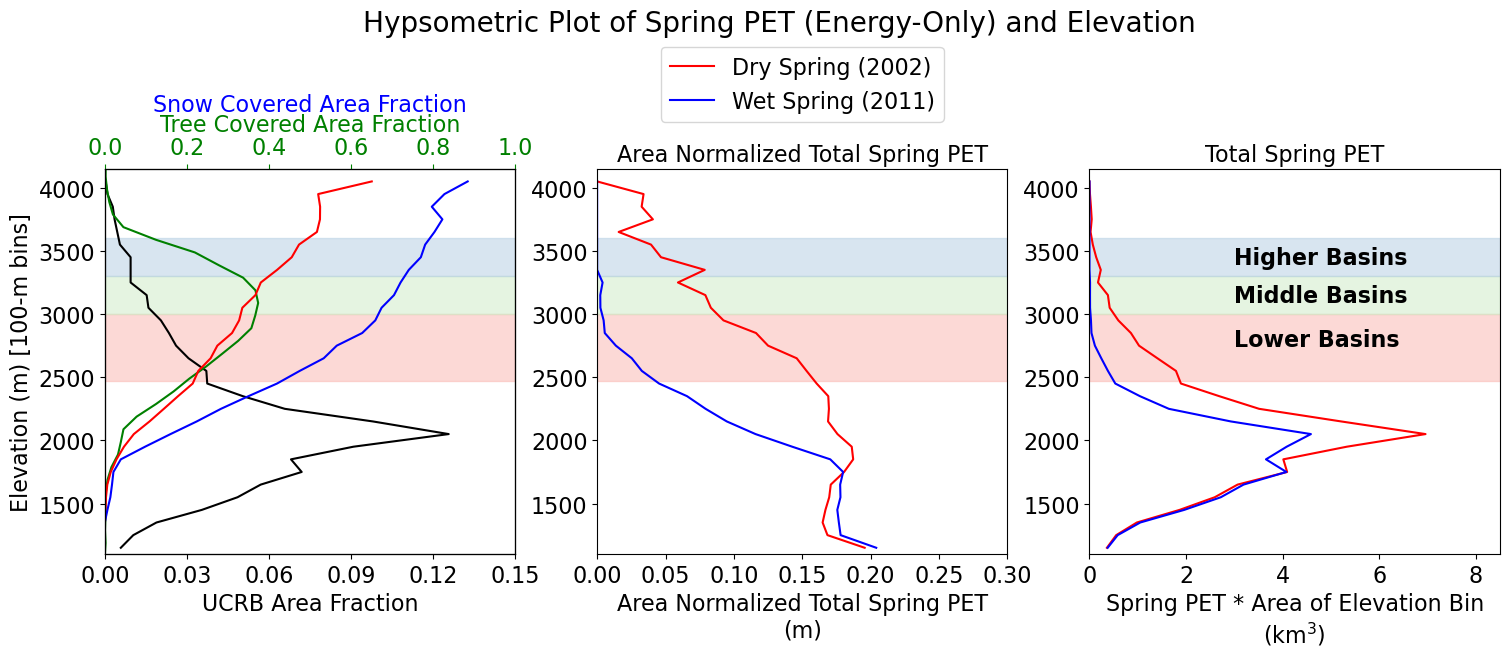

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(18,5))
ax = axs[0]
((dem_area.groupby_bins('elevation',
                        np.arange(era5_data.elevation.min(),
                                  era5_data.elevation.max(),
                                  100)).sum()).area/(dem_area.groupby_bins('elevation',
                                                                           np.arange(era5_data.elevation.min(),
                                                                                     era5_data.elevation.max(),
                                                                                     100)).sum()).area.sum()).plot(y='elevation_bins', 
                                                                                                                   ax=ax,
                                                                                                                   color='k')
ax.set_xlabel('UCRB Area Fraction')
ax2 = ax.twiny()
tree_covered_area_bins.plot(y='elevation_bins',ax=ax2, color='g')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=2002).plot(y='elevation_bins',ax=ax2, color='r', label='Dry Spring (2002)')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=2011).plot(y='elevation_bins',ax=ax2, color='b', label='Wet Spring (2011)')
ax2.set_xlabel('Tree Covered Area Fraction', color='g', fontsize=16)
# make the ticks green
for tl in ax2.get_xticklabels():
    tl.set_color('g')
    tl.set_fontsize(16)
ax2.tick_params(axis='x', colors='g')
ax2.set_xlim(0,1)
ax2.set_title('')
# add another axis on top of ax2
ax3 = ax.twiny()
ax3.set_xlim(0,1)
ax3.set_xlabel('Snow Covered Area Fraction', color='b', fontsize=16)
# move the xlable up a bit
ax3.xaxis.set_label_coords(0.5, 1.15)
# turn off the ticks and tick labels

ax3.set_xticks([])
ax3.set_xticklabels([])


ax.set_ylabel('Elevation (m) [100-m bins]')
ax.set_title('')
ax.set_xlim(0,0.15)
ax.set_xticks(np.arange(0,0.16,0.03))

ax = axs[1]
binned_et_ee = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_ee / 1000
# binned_et_ee = binned_et_ee * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_ee.sel(year=2002).plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Dry Spring (2002)')
binned_et_ee.sel(year=2011).plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wet Spring (2011)')
ax.legend(fontsize=16, bbox_to_anchor=(0.5, 1.22), loc='center')
ax.set_xlabel('Area Normalized Total Spring PET\n(m)')
ax.set_ylabel('')
ax.set_title('Area Normalized Total Spring PET')
ax.set_xlim(0,0.3)


ax = axs[2]
binned_et_ee = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).sum().et_ee / 1000
binned_et_ee = binned_et_ee * 10130.37725989001 * 10130.37725989001 / 1e9

binned_et_ee.sel(year=2002).plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Dry Spring (2002)')
binned_et_ee.sel(year=2011).plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wet Spring (2011)')
ax.set_xlabel('Spring PET * Area of Elevation Bin\n(km$^3$)')
ax.set_ylabel('')
ax.set_title('Total Spring PET')
ax.set_xlim(0,8.5)
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 2800,'Lower Basins ', ha='left', va='center', color='black', fontsize=16, weight='bold')
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 3150,'Middle Basins', ha='left', va='center', color='black', fontsize=16, weight='bold')
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 3450,'Higher Basins', ha='left', va='center', color='black', fontsize=16, weight='bold')
for ax in axs:
    ax.set_ylim(era5_data.elevation.min(),era5_data.elevation.max())
    # increase the font size for all x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    # increase the font size for x and y labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    # add a horizontal band between 2470 and 2900
    ax.axhspan(2470, 3000, color='#fbb4ae', alpha=0.5,)
    
    # add a horizontal band between 2900 and 3200
    ax.axhspan(3000, 3300, color='#ccebc5', alpha=0.5,)
    
    # add a horizontal band between 3200 and 3600
    ax.axhspan(3300, 3600, color='#b3cde3', alpha=0.5,)

fig.suptitle('Hypsometric Plot of Spring PET (Energy-Only) and Elevation', fontsize=20, y=1.2)